In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import json
import re
from scipy import stats

import pingouin as pg

import gc 

from statsmodels.stats.multicomp import pairwise_tukeyhsd

**Финальный срок сдачи: 16 апреля 21:00**

Вы работаете аналитиком в вертикале Недвижимость. Было решено развивать сегмент «Апартаменты» и
первыми продуктовыми инициативами запущенными в тест были:
- добавление чекбокса «Апартаменты в фильтр поиска;
- добавление быстрого фильтра в поиске:
    - «Однокомнатные апартаменты»
    - «Двухкомнатные апартаменты» и т.д.
- добавление планировки на карточку объявлений;
Для быстрой проверки гипотез было решено провести факторный эксперимент 
следующей конфигурации(одна строка — одна тестовая группа):
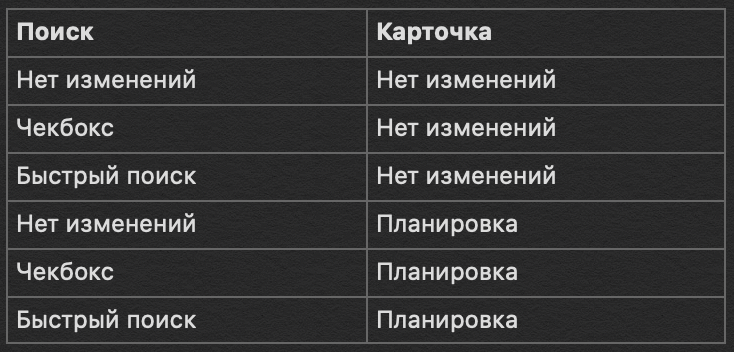


Есть гипотеза, что эти изменения приведут к росту конверсии из посетителя в покупателя.
Также есть дополнительная гипотеза о том, что изменения на поиске будут приводить к изменению структуры трафика на карточке и соответственно к изменению эффекта от улучшений на карточке.

Вам необходимо провести анализ эксперимента.

1. Сформирулируйте и формализуйте проверяемые продуктовые гипотезы. (2 балла)
2. Загрузите данные и постройте график распределений, по цвету раздели изменения на поиске, по строкам изменения на карточке. Попробуй проинтерпретировать изменения на основе визуального анализа. (2 балла)
3. Примени двухфакторную ANOVA и оцени изменения. (2 балла)
4. Примени критерий Тьюкки для нахождения парных изменений. (2 балла)
5. Сделайте продуктовые выводы по результатам эксперимента. (2 балла)


cookie_id - ид пользователя

split_group	- тестовая группа

searches - количество поисков

item_views - количество просмотров объявлений

changes_in_search - изменение в поиске

changes_in_item - изменение в на карточке


# Основные гипотезы

* $H_0^{0}$ - изменение группы фичей поиска не влияет на метрики контактов, просмотров и поиска
* $H_0^{1}$ - изменение группы фичей карточки не влияет на метрики контактов, просмотров и поиска
* $H_0^{2}$ - отсутствует взаимодействие факторов

Очевидно, что позитивное изменение должно быть в виде увеличения всех трех метрик. Также приемлим вариант, что будет улучшение двух метрик просмотров и контактов при неизменной метрике поиска.

# Предобработка данных

In [2]:
df = pd.read_csv('apartaments_dev.csv')

In [3]:
df.head()

,cookie_id,searches,item_views,contacts,changes_in_search,changes_in_item
0,218642754133,285,465,55,no_changes,no_changes
1,220039555098,0,11,0,no_changes,no_changes
2,223889500056,2,1,0,no_changes,no_changes
3,225831069301,5,3,0,no_changes,no_changes
4,228425772447,0,1,0,no_changes,no_changes


In [4]:
df.shape

(3315726, 6)

In [5]:
df[df['cookie_id'].duplicated()].shape

(0, 6)

In [6]:
df['changes_in_search'].unique()

array(['no_changes', 'checkbox', 'fast_search'], dtype=object)

In [7]:
df['changes_in_item'].unique()

array(['no_changes', 'add_plan'], dtype=object)

In [8]:
df[['searches', 'item_views', 'contacts']].describe()

,searches,item_views,contacts
count,3.315726e+06,3.315726e+06,3.315726e+06
mean,3.695403e+01,3.224695e+01,1.058361e+00
std,1.674618e+02,1.476740e+02,9.692643e+00
min,0.000000e+00,0.000000e+00,-3.000000e+00
25%,2.000000e+00,2.000000e+00,0.000000e+00
50%,6.000000e+00,6.000000e+00,0.000000e+00
75%,2.100000e+01,2.200000e+01,0.000000e+00
max,7.153600e+04,4.184600e+04,3.579000e+03


In [9]:
(df['contacts'] < 0).mean()

0.002689607042318937

Отрицательные контакты? Что это вообще такое? Ошибка в данных => выбрасываем, благо таких мало относительно всех

In [10]:
df.searches.max()

71536

In [11]:
df.item_views.max()

41846

71 и 41 тысяча поисков и просмотров - фродер? Глянем, что это вообще такое

In [12]:
df.loc[df.searches.argmax()]

cookie_id            3805907051810
searches                     71536
item_views                    2326
contacts                       216
changes_in_search       no_changes
changes_in_item           add_plan
Name: 2131353, dtype: object

In [13]:
df.loc[df.item_views.argmax()]

cookie_id            3780329505713
searches                      7550
item_views                   41846
contacts                         3
changes_in_search       no_changes
changes_in_item           add_plan
Name: 1780084, dtype: object

71 тысяча поисков - какой-то очень избирательный клиент, тем ни менее, кажется, что он весьма активный и это не бот. А вот со вторым есть сомнения, так как крайне низкая конверсия в контакт. Я бы предложил убрать такого клиента, несмотря на наличие в целом контактов. В целом все равно, кажется, стоит сократить до 10000 оба поля

In [14]:
(df['item_views'] < 10_000).mean()

0.9999752693678549

In [15]:
CONST_THRESHOLD = 10_000

In [16]:
filter_outliners = ((df['item_views'] < CONST_THRESHOLD) & 
                    (df['searches'] < CONST_THRESHOLD) & 
                    (df['contacts'] < 30))

In [17]:
df = df[filter_outliners]

In [18]:
df.shape

(3302216, 6)

In [19]:
df[df.contacts<0]['contacts'].value_counts()

-1    8837
-2      80
-3       1
Name: contacts, dtype: int64

In [20]:
df['contacts'] = df['contacts'].replace([-1, -2, -3], 0)

In [21]:
df.columns

Index(['cookie_id', 'searches', 'item_views', 'contacts', 'changes_in_search',
       'changes_in_item'],
      dtype='object')

In [22]:
sns.set(style="white",
        palette="pastel",
        color_codes=True,
        rc={'figure.figsize':(12,15),
            'figure.dpi':400})

In [119]:
sns.displot(df, x='contacts',
            hue='changes_in_search',
            col='changes_in_item',
            kind='kde', 
            height=5, aspect=1.5)
plt.ylim(0, 0.08)
plt.xlim(0.5, 15)
plt.show()

# Построение визуализаций

## Для метрики контактов

Примечание: если перезапустить обработку, то можно будет нажимать на графики, приближая их.

<Figure size 6800x3600 with 0 Axes>

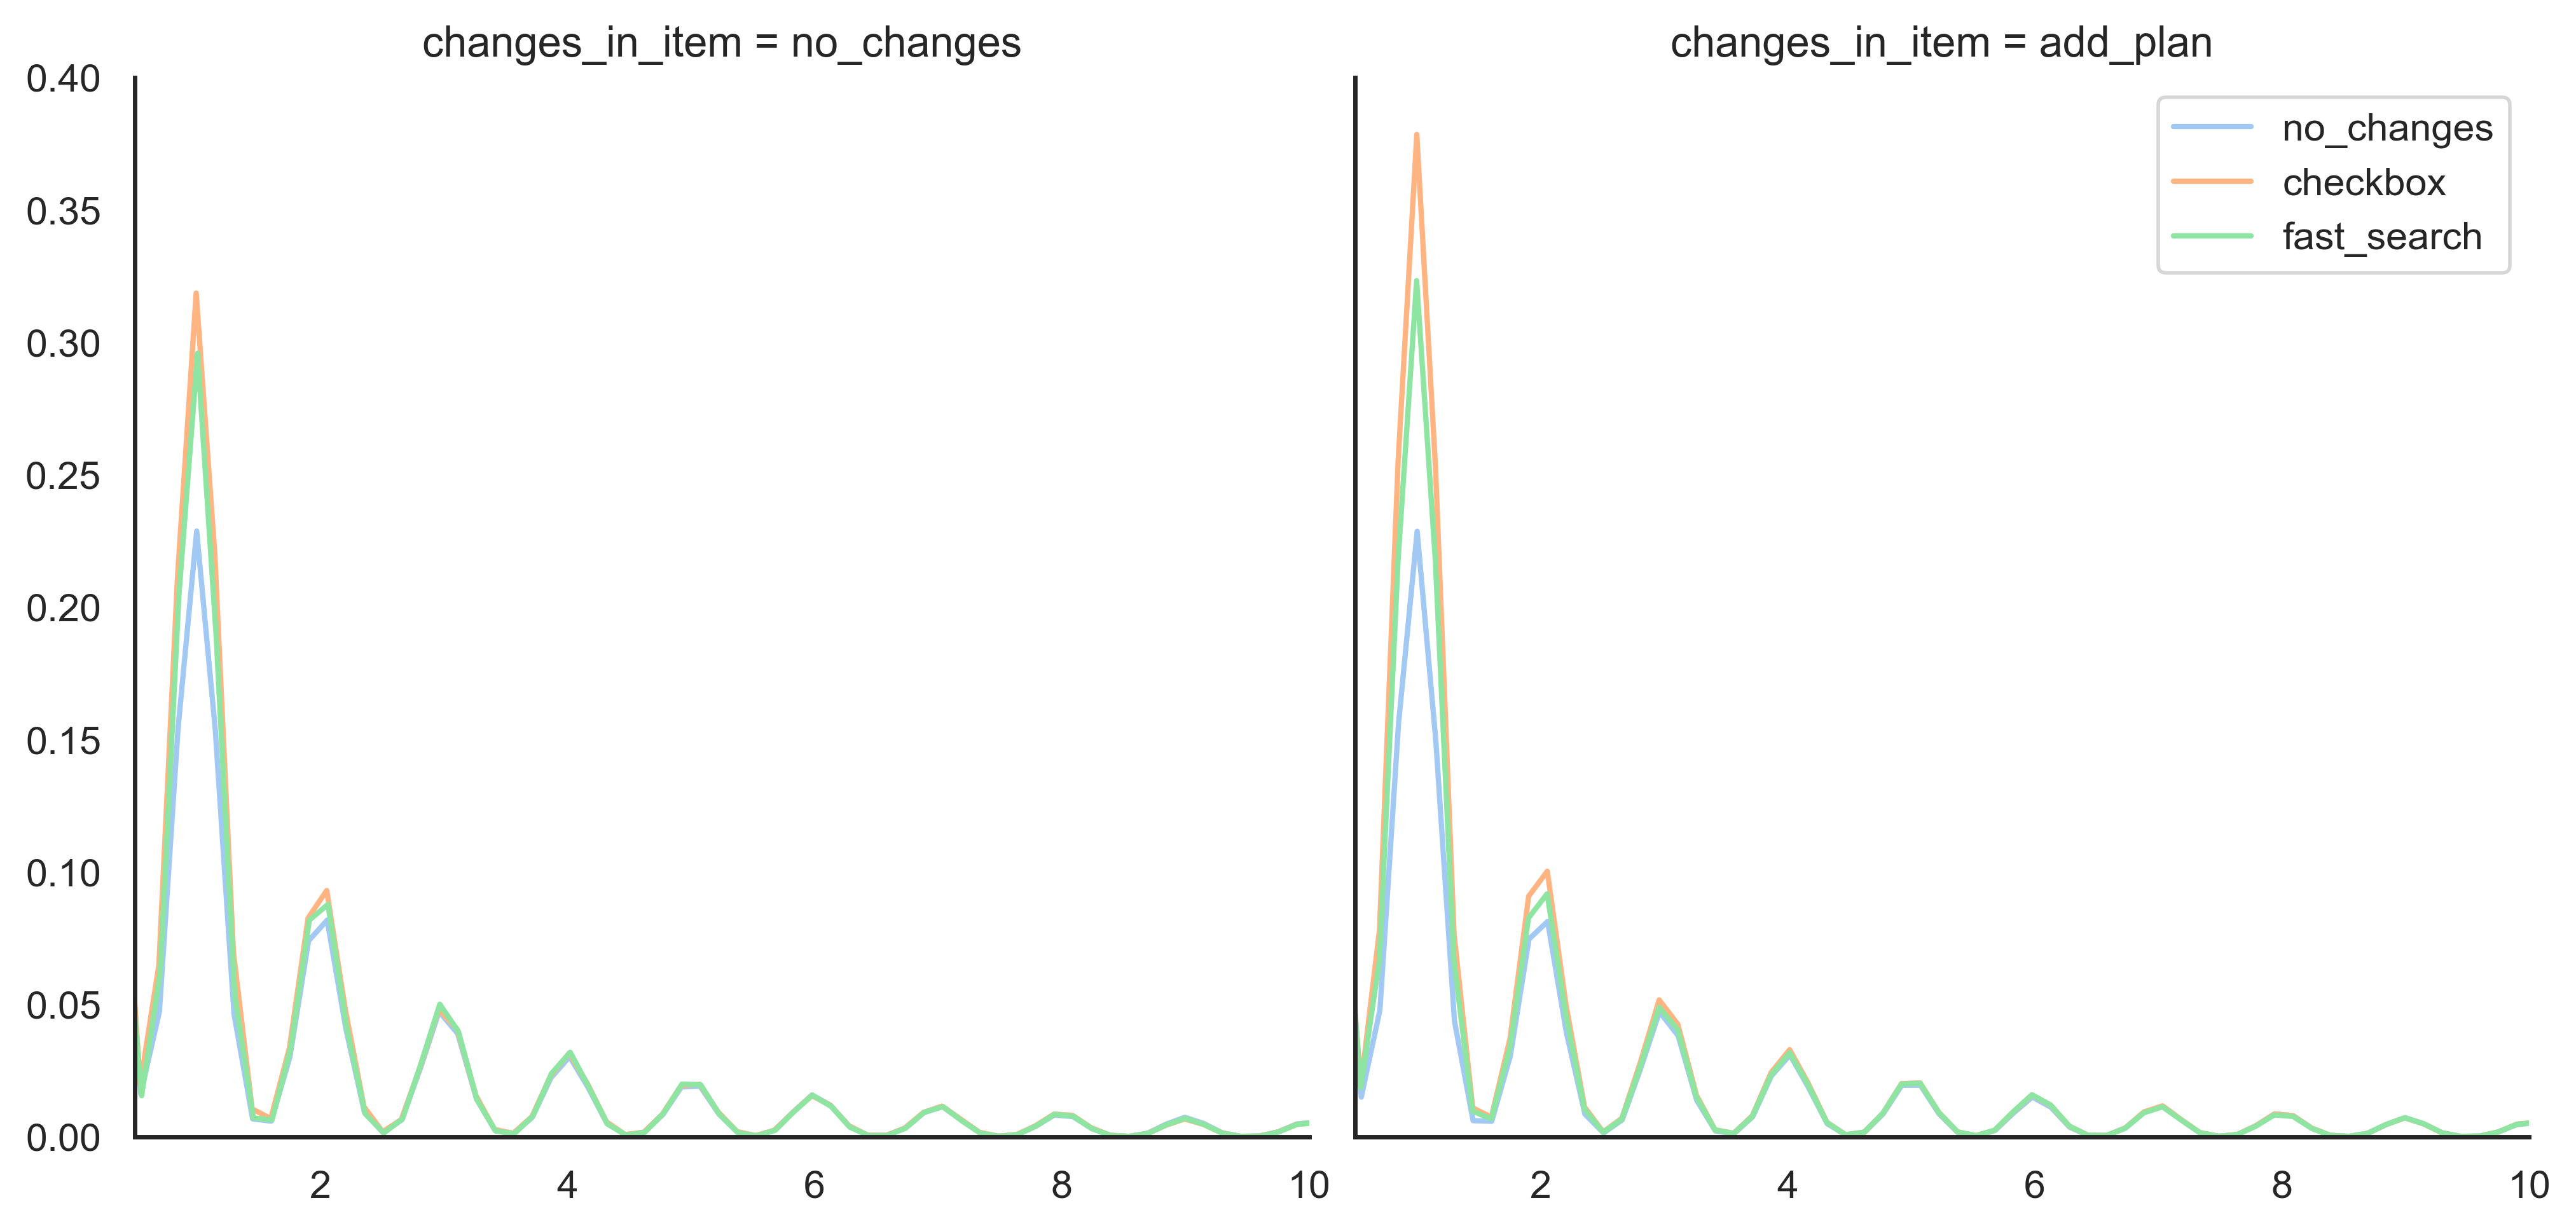

In [132]:
plt.figure(figsize=(17, 9))
g = sns.FacetGrid(df, col='changes_in_item', hue='changes_in_search', col_wrap=3, height=5)
g.map_dataframe(sns.kdeplot, x='contacts')
plt.xlim(0.5, 10)
plt.ylim(0, 0.4)
g.axes[-1].legend()
plt.show()

С виду для добавления checkbox и для fast_search результаты лучше для метрики контактов. Checkbox разительно лучше визуально

## Для метрики количества просмотров

<Figure size 6800x3600 with 0 Axes>

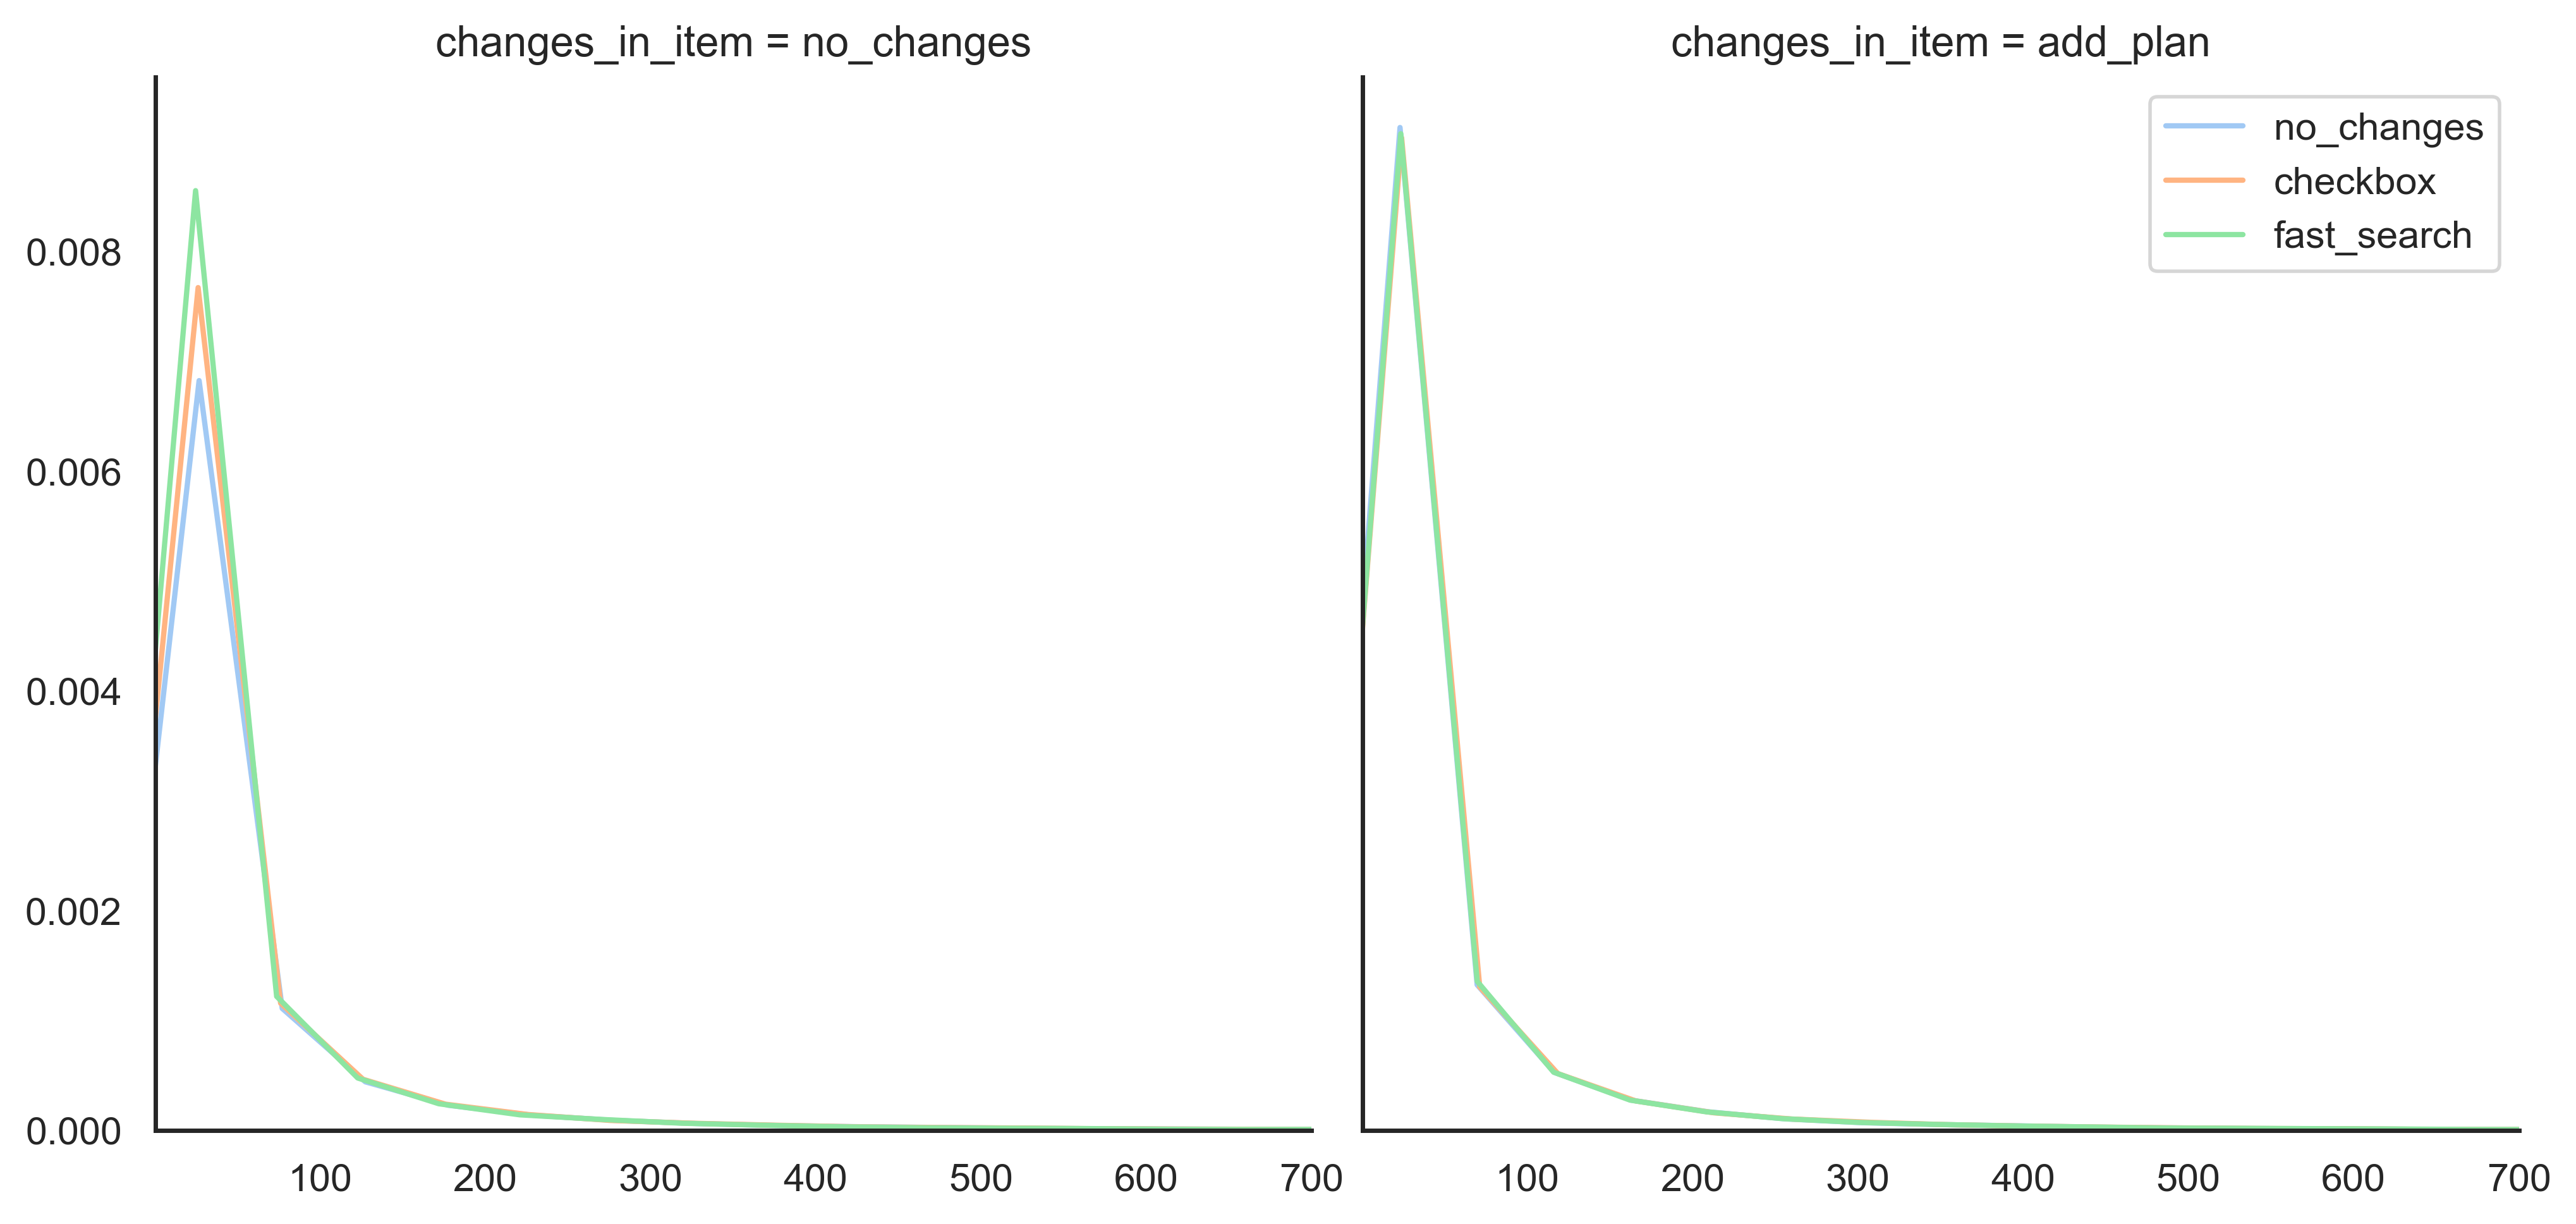

In [150]:
plt.figure(figsize=(17, 9))
g = sns.FacetGrid(df, col='changes_in_item', hue='changes_in_search', col_wrap=3, height=5)
g.map_dataframe(sns.kdeplot, x='item_views')
plt.xlim(0.5, 700)
#plt.ylim(0, 0.4)
g.axes[-1].legend()
plt.show()

Видим, что для метрики количества просмотров объявлений в целом тоже видим положительное изменение (на глаз).

## Для метрики количества поиска

<Figure size 6800x3600 with 0 Axes>

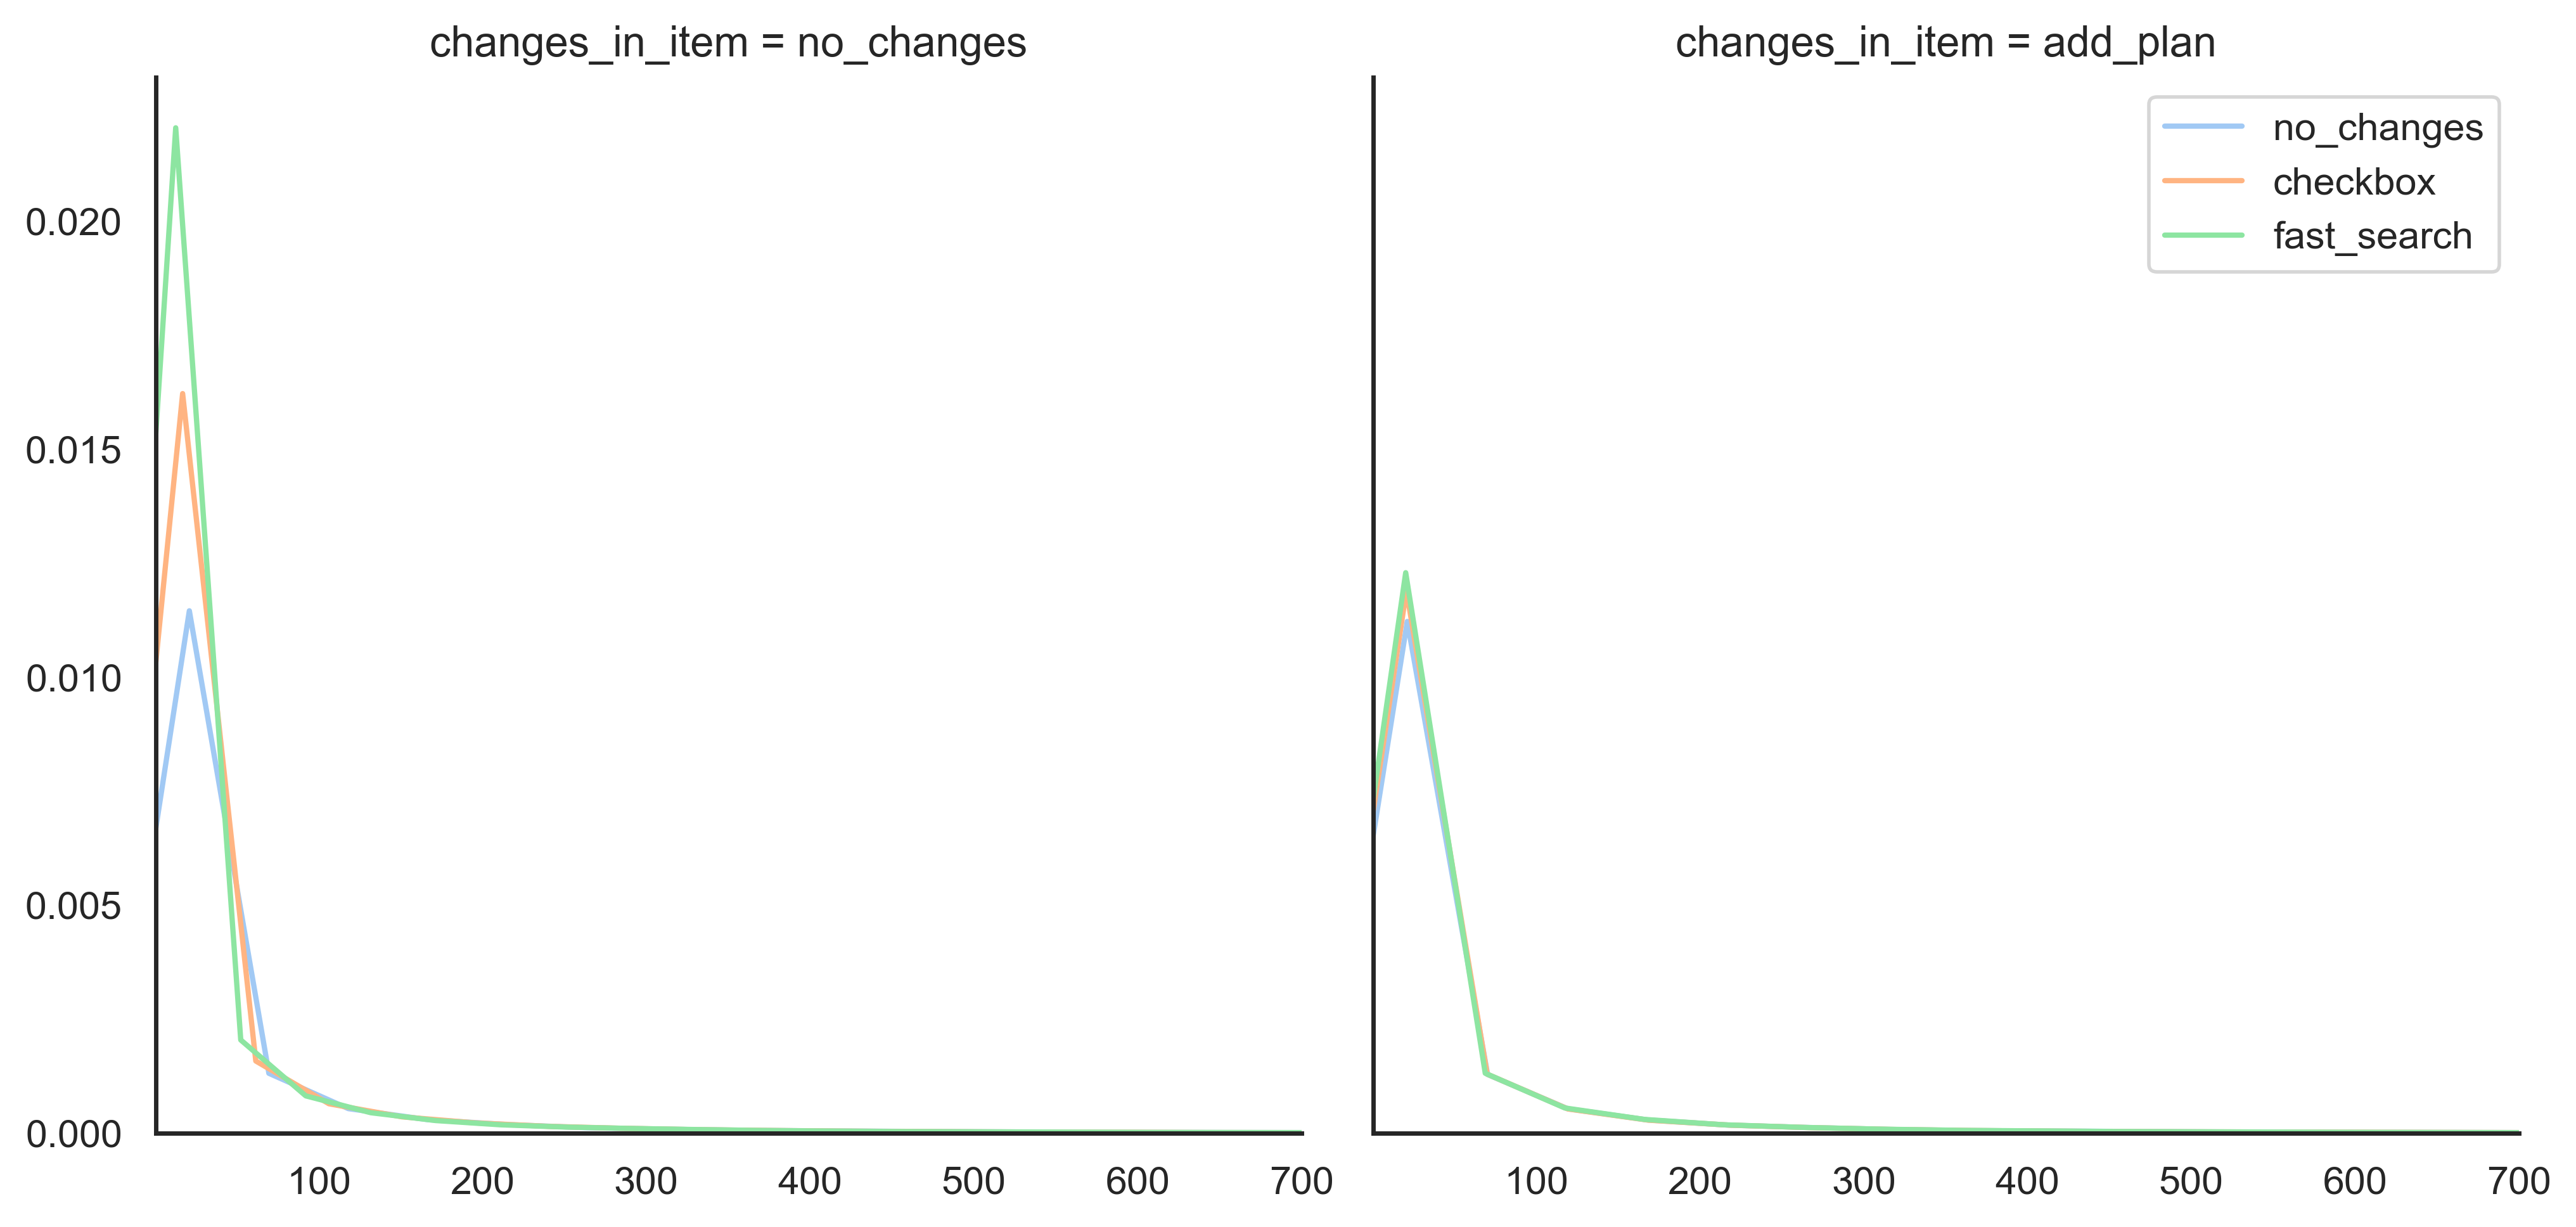

In [147]:
plt.figure(figsize=(17, 9))
g = sns.FacetGrid(df, col='changes_in_item', hue='changes_in_search', col_wrap=3, height=5)
g.map_dataframe(sns.kdeplot, x='searches')
plt.xlim(0.5, 700)
#plt.ylim(0, 0.4)
g.axes[-1].legend()
plt.show()

А вот для метрики количества поиска видим ухудшение при добавлении плана, что, конечно, имеет двоякое ощущение, с одной стороны уменьшение поиска это негативный ключ, так как мы имеем меньше возможности для рекламы пользователя, с другой стороны, одновременное увеличение конверсии в контакт должно говорить о том, что мы имеем сильное увеличение клиентского опыта, что позитивно.

# Anova 

In [23]:
df['changes_in_search'].unique()

array(['no_changes', 'checkbox', 'fast_search'], dtype=object)

In [24]:
df['changes_in_item'].unique()

array(['no_changes', 'add_plan'], dtype=object)

## Для метрики контактов

In [25]:
anova = pg.anova(dv='contacts', between=['changes_in_search', 'changes_in_item'], data=df, detailed=True)

In [26]:
anova

,Source,SS,DF,MS,F,p-unc,np2
0,changes_in_search,3.781696e+03,2.0,1890.847924,334.849138,3.904910e-146,0.000203
1,changes_in_item,2.681006e+02,1.0,268.100642,47.477784,5.564074e-12,0.000014
2,changes_in_search * changes_in_item,2.395149e+02,2.0,119.757425,21.207772,6.160855e-10,0.000013
3,Residual,1.864713e+07,3302210.0,5.646865,NaN,NaN,NaN


p-value очень низкие, значит есть связи между факторами в рамках метрики контактов, что позитивно, так как это наша ключевая метрика.

## Для метрики просмотра объявлений

In [27]:
anova_item = pg.anova(dv='item_views', between=['changes_in_search', 'changes_in_item'], data=df, detailed=True)

In [28]:
anova_item

,Source,SS,DF,MS,F,p-unc,np2
0,changes_in_search,5.586727e+05,2.0,279336.374649,23.122462,9.080561e-11,1.400404e-05
1,changes_in_item,4.463810e+03,1.0,4463.809509,0.369498,5.432780e-01,1.118942e-07
2,changes_in_search * changes_in_item,3.350620e+04,2.0,16753.100281,1.386761,2.498834e-01,8.398983e-07
3,Residual,3.989313e+10,3302210.0,12080.736702,NaN,NaN,NaN


Мы видим, что лишь фактор изменения для поиска имеет влияние на метрике просмотра. Мы отвергаем гипотезу в пользу альтернативы, ведь один pvalue < 0.01

## Для метрики поиска

In [29]:
anova_search = pg.anova(dv='searches', between=['changes_in_search', 'changes_in_item'], data=df, detailed=True)

In [30]:
anova_search

,Source,SS,DF,MS,F,p-unc,np2
0,changes_in_search,9.798818e+03,2.0,4899.409072,0.287603,0.750060,1.741879e-07
1,changes_in_item,2.344229e+03,1.0,2344.229197,0.137610,0.710669,4.167202e-08
2,changes_in_search * changes_in_item,1.134736e+04,2.0,5673.678706,0.333053,0.716732,2.017154e-07
3,Residual,5.625427e+10,3302210.0,17035.341449,NaN,NaN,NaN


Все pvalue огромные, поэтому нет видим стат значимости в изменениях для метрики поиска.

# Тест Тьюки

In [31]:
df['group'] = df['changes_in_search'] + '|' + df['changes_in_item']

In [32]:
df['group'].value_counts()

no_changes|add_plan       550754
fast_search|add_plan      550570
checkbox|add_plan         550416
no_changes|no_changes     550249
checkbox|no_changes       550205
fast_search|no_changes    550022
Name: group, dtype: int64

## Метрика контактов

P.S. во всех таблицах снизу meandiff = mean(group2) - mean(group1)

In [33]:
print(pairwise_tukeyhsd(endog=df['contacts'], groups=df['group'], alpha=0.01))

                Multiple Comparison of Means - Tukey HSD, FWER=0.01                 
        group1                 group2         meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------
     checkbox|add_plan    checkbox|no_changes  -0.0307  0.001 -0.0459 -0.0155   True
     checkbox|add_plan   fast_search|add_plan  -0.0369  0.001 -0.0522 -0.0217   True
     checkbox|add_plan fast_search|no_changes  -0.0664  0.001 -0.0816 -0.0511   True
     checkbox|add_plan    no_changes|add_plan  -0.1011  0.001 -0.1163 -0.0858   True
     checkbox|add_plan  no_changes|no_changes   -0.095  0.001 -0.1102 -0.0798   True
   checkbox|no_changes   fast_search|add_plan  -0.0062 0.7132 -0.0215   0.009  False
   checkbox|no_changes fast_search|no_changes  -0.0357  0.001 -0.0509 -0.0204   True
   checkbox|no_changes    no_changes|add_plan  -0.0704  0.001 -0.0856 -0.0551   True
   checkbox|no_changes  no_changes|no_changes  -0.0643  0.001 -0.

Видим, что почти все гипотезы о равенстве и независимости отвергаются, однако, можем заменить, что добавление плана не дает стат. значимого результата. Тем ни менее, мы имеем сильное влияние на целевой метрике для наших фичей. Можем сравнить с контрольной выборкой (no changes | no changes) и понять, что в целом fast_search, добавление checkbox-а дают стат. значимо лучший результат. Более того, видим, что в целом добавление checkbox оказывает бОльшее влияние, чем fast_search.

## Метрика просмотров объявлений

In [34]:
print(pairwise_tukeyhsd(endog=df['item_views'], groups=df['group'], alpha=0.01))

                Multiple Comparison of Means - Tukey HSD, FWER=0.01                 
        group1                 group2         meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------
     checkbox|add_plan    checkbox|no_changes   0.2196    0.9 -0.4852  0.9244  False
     checkbox|add_plan   fast_search|add_plan  -0.4359 0.2974 -1.1406  0.2688  False
     checkbox|add_plan fast_search|no_changes  -0.2236 0.8928 -0.9284  0.4813  False
     checkbox|add_plan    no_changes|add_plan  -0.7895 0.0023 -1.4941 -0.0848   True
     checkbox|add_plan  no_changes|no_changes  -1.0008  0.001 -1.7056  -0.296   True
   checkbox|no_changes   fast_search|add_plan  -0.6556 0.0217 -1.3603  0.0492  False
   checkbox|no_changes fast_search|no_changes  -0.4432 0.2795 -1.1481  0.2618  False
   checkbox|no_changes    no_changes|add_plan  -1.0091  0.001 -1.7138 -0.3044   True
   checkbox|no_changes  no_changes|no_changes  -1.2204  0.001 -1.

Здесь уже ситуация совсем иная - отвергаются лишь 4 гипотезы, тем ни менее, видим, что fast-search, так и добавление checkbox-а дает стат.значимое улучшение, как и fast_search, но опять же checkbox лучше.

## Метрика поиска

In [35]:
print(pairwise_tukeyhsd(endog=df['searches'], groups=df['group'], alpha=0.01))

                Multiple Comparison of Means - Tukey HSD, FWER=0.01                
        group1                 group2         meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------------------
     checkbox|add_plan    checkbox|no_changes   0.0688    0.9 -0.7682 0.9058  False
     checkbox|add_plan   fast_search|add_plan   0.0117    0.9 -0.8251 0.8485  False
     checkbox|add_plan fast_search|no_changes  -0.1998    0.9 -1.0368 0.6372  False
     checkbox|add_plan    no_changes|add_plan  -0.0527    0.9 -0.8894 0.7841  False
     checkbox|add_plan  no_changes|no_changes  -0.0699    0.9 -0.9068 0.7671  False
   checkbox|no_changes   fast_search|add_plan  -0.0571    0.9  -0.894 0.7798  False
   checkbox|no_changes fast_search|no_changes  -0.2686 0.8856 -1.1057 0.5685  False
   checkbox|no_changes    no_changes|add_plan  -0.1215    0.9 -0.9583 0.7154  False
   checkbox|no_changes  no_changes|no_changes  -0.1387    0.9 -0.9757 0.6984

К сожалению (или счастью?), не видим стат.значимых изменений для метрики поиска.

# Выводы

* Так как основная наша продуктовая гипотеза была в том, что будет увеличение как минимум двух метрик (как минимум просмотра объявлений и контактов при неизменной метрике поиска), то можем говорить о том, что добавление checkbox-а как раз соответствует данной гипотезе.
* Для add_plan видим увеличение на метрике контактов, но отсутствие стат.значимого изменения других метрик, поэтому такой результат тоже в теории приемлим, так как в целом имеем увеличение конверсии непосредственно в контакт при неизменности остальной воронки.
* Fast-search также дает стат.значимое улучшение двух основных метрик, но тем ни менее, эффект от него ниже, чем от добавление checkbox-а той же самой группы, поэтому разумнее использовать checkbox.
* Видим, что есть зависимость для контактов влияния изменения в поиске и карточке.

Итоговые рекомендации по продукту:
1. Можем провести дополнительные тесты по добавлению checkbox-а на более большую выборку и провести уже АБ-тест, затем подтвердить стат.значимое улучшение
2. Затем после эксперимента по checkbox и раскатки его на пользователях можем провести эксперимент на add_plan, чтобы также проверить на АБ (уберем воздействие факторов поиска на фактор карточки)